# Eguzki sistemaren 5 gorputzeko eredua

Eguzki sistemaren 5 gorputzeko sistema batekin egingo dugu lan. Bertan, bost masa puntual Newton-en grabitate legearen arabera mugituko dira: Eguzkia, Jupiter, Saturno, Urano, eta Neptuno.

<ul id="top">



<a href="#top">Ir al inicio</a>

## Paketeak eta funtzioak kargatu

In [1]:
using LinearAlgebra
using Plots
using OrdinaryDiffEq
using Polynomials

In [2]:
include("KanpokoEguzkiSistema.jl")

NbodyODE2! (generic function with 1 method)



## 1 - $N$ gorputzeko eredua matematikoaren definizioa


Sistemaren energia, $q_1,\ldots,q_N \in \mathbb{R}^3$  kokapenen eta  $v_1,\ldots,v_N \in \mathbb{R}^3$  abiadura bektoreen funtzio gisa honakoa da:

\begin{equation*}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{equation*}


Ekuazio diferentzialen sistema:
\begin{equation}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split} \tag{1}
\end{equation}

Sistema hori modu trinkoan horrela adieraziko dUgu:

\begin{equation*}
\frac{d u}{dt} = f(t,u,p). \tag{2}
\end{equation*}



Egoera aldagaiak, bektore batean bildU beharrean, hiru indizeko array batean horrela gordeko ditugu:

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{3\times N \times 2}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

Aldiz, parametro konstanteen bektorea honakoa da:

\begin{equation*}
p = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

**Unitate neurriak:** distantzia unitate astronomikotan (AU), eta denbora egunetan.

### 1.1 NbodyEnergy(u,p) funtzioa inplementatu, sistemaren energia bider $G$ kalkulatzen duena

In [3]:

function NbodyEnergy(u,p)
     N = length(p)
     T = 0.
     U = 0.
     for i in 1:N
        qi = u[:,i,1]
        vi = u[:,i,2]
        Gmi = p[i]
        T += Gmi*dot(vi,vi)
        for j in (i+1):N
           qj = u[:,j,1]
           Gmj = p[j]
           qij = qi - qj
           U -= Gmi*Gmj/norm(qij)
        end
     end
    1/2*T + U
end


NbodyEnergy (generic function with 1 method)

### 1.2 $N$ gorputzeko problema (2) formatuan jartzeko behar den NbodyODE!(dU,u,p,t) funtzioa inplementatu. 

In [4]:
function NbodyODE!(du,u,p,t)
     # Hemen, du taulan jarriko dira $f(t,u,p)$ aplikazioaren osagaiak. 
     N = length(p)
     du[:,:,2] .= 0
     for i in 1:N
        xi = u[1,i,1]
        yi = u[2,i,1]
        zi = u[3,i,1]
        Gmi = p[i] 
        for j in (i+1):N
           xij = xi - u[1,j,1]
           yij = yi - u[2,j,1]
           zij = zi - u[3,j,1]
           Gmj = p[j] 
           dotij = xij^2+yij^2+zij^2
           auxij = 1/(sqrt(dotij)*dotij) 
           dotij = xij^2+yij^2+zij^2
           invdotij = 1/dotij
           sqrtinvdotij = sqrt(invdotij) 
           auxij = invdotij * sqrtinvdotij 
           du[1,i,2] -= Gmj*auxij*xij
           du[1,j,2] += Gmi*auxij*xij
           du[2,i,2] -= Gmj*auxij*yij
           du[2,j,2] += Gmi*auxij*yij
           du[3,i,2] -= Gmj*auxij*zij
           du[3,j,2] += Gmi*auxij*zij
        end
     end
    du[:,:,1] .= u[:,:,2]   
    return nothing
end




NbodyODE! (generic function with 1 method)

##### <a href="#top">Hasierara</a>

## 2 - Eguzki sistemaren bilakaeraren datu "errealak"

KanpokoEguzkiSistemarenDatuak(tend) funtzioak kanpoko eguzki-sistemaren datu "errealak" itzultzen dizkigu $[0,t_{end}]$ denbora-tartearen diskretizazio uniforme jakin baterako. Hemen, $t_{end}=60182$ da, Neptunoren periodoa egunetan.

Datu horiek lortzeko, 16 gorputzeko eredu errealistago baten simulazioa egin da: eguzkia, eguzki-sistemako zortzi planetak, ilargia, Pluto, eta Ceres, Pallas, Vesta, Iris eta Bamberga (Marte eta Jupiterren arteko asteroide gerrikoko bost objektu handienak). Hasierako datuak 1969ko ekainaren 28koak dira (Julian Day (TDB) 2440400.5), DE430 efemerideetatik lortutakoak.

In [5]:
tend= 60182. # Neptunoren gutxi gorabeherako periodoa egunetan
datos_t, datos_u = KanpokoEguzkiSistemarenDatuak(tend);

### 2.1 - Hiru irudi lortu, OXY, OXZ eta OYZ planoetako proiekzioei dagozkienak, hurrenez hurren, kanpoko lau planeten orbiten grafikoekin.


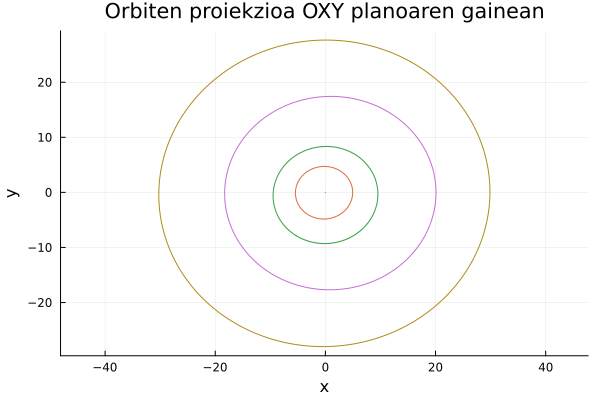

In [6]:
pl = plot(title="Orbiten proiekzioa OXY planoaren gainean", 
            xlabel="x", ylabel="y", legend=false, aspect_ratio=1)

  for j = 1:5
    x  = [u[1,j,1] for u in datos_u]
    y  = [u[2,j,1] for u in datos_u] 
    pl = plot!(x,y) 
  end 
display(pl)

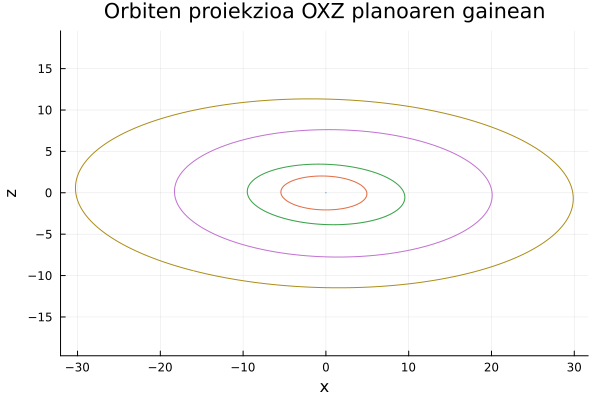

In [7]:
pl = plot(title="Orbiten proiekzioa OXZ planoaren gainean", 
            xlabel="x", ylabel="z", legend=false, aspect_ratio=1)

  for j = 1:5
    x  = [u[1,j,1] for u in datos_u]
    z  = [u[3,j,1] for u in datos_u] 
    pl = plot!(x,z) 
  end 
display(pl)

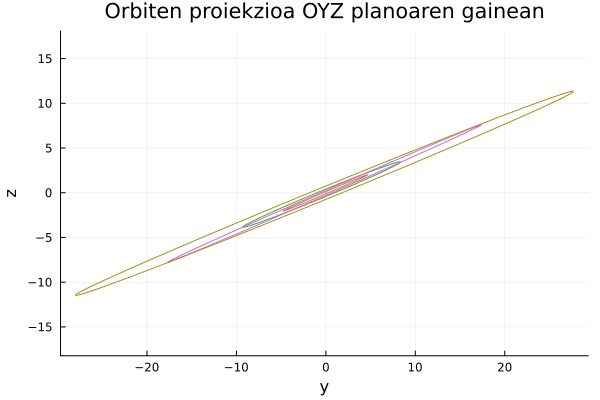

In [8]:
 pl = plot(title="Orbiten proiekzioa OYZ planoaren gainean", 
            xlabel="y", ylabel="z", legend=false, aspect_ratio=1)

  for j = 1:5
    y  = [u[2,j,1] for u in datos_u]
    z  = [u[3,j,1] for u in datos_u] 
    pl = plot!(y,z) 
  end 
display(pl)

##### <a href="#top">Hasierara</a>

## 3 - Kanpoko eguzki sistemaren eredu matematikoaren soluzioa

KanpokoEguzkiSistemarenHasierakoDatuak() honakoa itzultzen digu:

- Sistemaren hasierako $u_0$ egoera 1969ko ekainaren 28an (Julian Day (TDB) 2440400.5), DE430 efemerideetatik lortuak), 
- Parametro konstanteen osagaien $p_i = G\, m_i$  ($i=1,2,3,4,5$) balioak, eta 
- Gorputz bakoitzaren izenen zerrenda. 

In [9]:
u0, p, bodylist = KanpokoEguzkiSistemarenHasierakoDatuak()
GmNeptuno = p[5]
N = length(p)
bodylist

1×5 Matrix{String}:
 "Barneko Eguzki Sistema"  "Jupiter"  "Saturno"  "Urano"  "Neptuno"

Neptunori dagokion $G\, m_5 $-ren balioa 1992an balio hori zuzendu aurretik zegoena da.
(1989an Neptunoren orbitatik gertu Voyager2 pasa zenean jasotako datuekin zuzendu zen Neptunoren masa.)

### 3.1 - Bost gorputzen problemaren emaitzak lortu  datos_t taulan emandako $t_1,\ldots, t_m $ denboretarako, horretarako Vern9() metodoa aplikatuz  $h = 300$ urrats luzerarekin

In [10]:
tspan = (0.,datos_t[end])
prob = ODEProblem(NbodyODE!, u0, tspan, p)
h = 300.
sol = solve(prob, Vern9(), adaptive=false, dt=h, saveat=datos_t)
sol.retcode

:Success

### 3.2 - Energiaren errore erlatiboaren bilakaera irudikatu eskala logaritmikoan


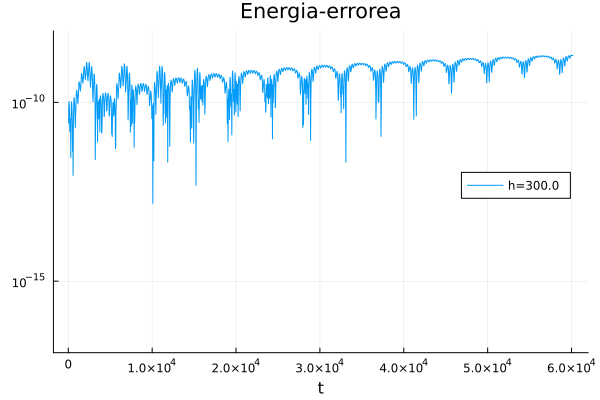

In [11]:
E0 = NbodyEnergy(u0,p)
EE = [abs((NbodyEnergy(u,p)-E0)/E0) for u in sol.u]
pl = plot(sol.t, EE, xlabel="t", title="Energia-errorea", 
                     yscale=:log10, ylims=(1e-17,1e-8),
                     label="h=$h", legend=:right )

### 3.3 -  Kalkuluak errepikatu $h = 150$ urrats-luzerarekin, eta gehitu aurreko irudiari emaitza berrien energia-errore erlatiboaren bilakaeraren grafikoa. Gehitu, halaber, energia-errore-erlatiboaren grafikoa $h = 75$ urrats-luzeraren kasuan


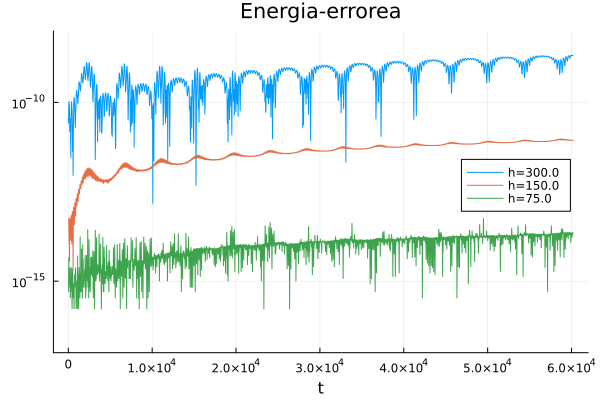

In [12]:
    h /= 2
    sol2 = solve(prob, Vern9(), adaptive=false, dt=h, saveat=datos_t)
    EE = [abs((NbodyEnergy(u,p)-E0)/E0) for u in sol2.u]
    plot!(sol.t, EE, label="h=$h", legend=:right )

    h /= 2
    sol2 = solve(prob, Vern9(), adaptive=false, dt=h, saveat=datos_t)
    EE = [abs((NbodyEnergy(u,p)-E0)/E0) for u in sol2.u]
    plot!(sol.t, EE, label="h=$h", legend=:right )


### 3.4 Alde batetik datu errealak  eta bestetik zenbakizko integrazioarekin lortutako emaitzak hartuz irudi bakar batean irudikatu planeta bakoitzaren kokapenen diferentzien normaren bilakaera (eskala logaritmikoan)


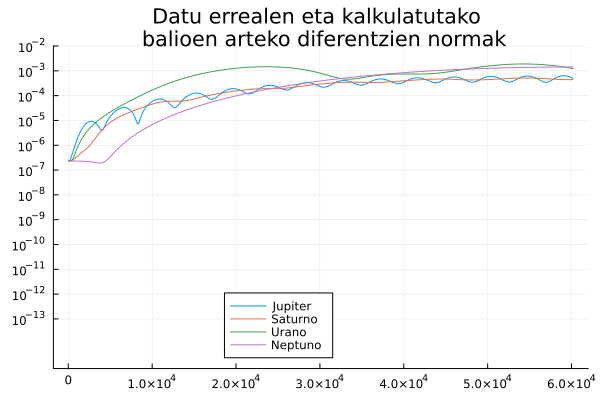

In [13]:
errores = [sol.u[i] - datos_u[i] for i in 1:length(datos_t)]


ErroresPosicion(j)=[norm(errores[i][:,j,1]  .+ eps(0.01))  for i in 1:length(datos_t)]

ind = 2:N

plot(datos_t, [ErroresPosicion(i) for i in ind], title="Datu errealen eta kalkulatutako \n balioen arteko diferentzien normak",
               yscale=:log10, labels=bodylist[:,ind], legend=:bottom, ylim=(1e-15,1e-2), 
               yticks= 10. .^ (-13:-1))

### 3.5 Vern9 metodoarekin eta $h=150$ urrats luzerarekin kalkulatutako emaitzen posizioetako zenbakizko erroreak estimatu (bigarren gaiko amaierako teknika erabiliz), eta 3.4 ataleko irudi berean gehitu errore horien normaren bilakaeraren grafikoak (eskala logaritmikoan).


In [14]:
prob = ODEProblem(NbodyODE!, u0, tspan, p)
@time sol = solve(prob, Vern9(), adaptive=false, dt=150., saveat=datos_t)
@time sol2 = solve(prob, Vern9(), adaptive=false, dt=300., saveat=datos_t)
sol.retcode

  0.003503 seconds (18.93 k allocations: 4.287 MiB)
  0.002263 seconds (11.49 k allocations: 2.542 MiB)


:Success

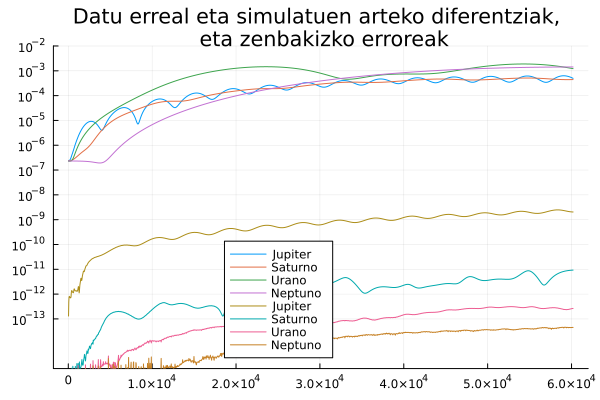

In [15]:
order = 9
fakt = 1/(2^order-1)
errores = [fakt*(sol.u[i] - sol2.u[i]) for i in 1:length(datos_t)]


plot!(datos_t, [ErroresPosicion(i) for i in ind], 
                title="Datu erreal eta simulatuen arteko diferentziak, \n eta zenbakizko erroreak",
               yscale=:log10, labels=bodylist[:,ind])

### 3.6 Vern9 metodoarekin eta $h=150$ urrats luzerarekin kalkulatutako emaitzen posizioetako zenbakizko errore estimatuen tamainia ikusirik, 3.4 atalean lortutako grafikoa fidagarria dela esango zenuke?


>
> Erantzuna hemen idatzi

##### <a href="#top">Ir al inicio</a>

## 4 - Neptunoren masaren doikuntza

Atal honetan, $p_5 = G\, m_5$ parametroa doitzen saiatuko gara, parametroaren balio horretarako lortutako emaitza simulatuak, gutxieneko karratuen zentzuan, datu errealekin (ahal den neurrian)  bat etor daitezen.


### 4.1 - Errfcn (x) funtzio bat definitu, parametroaren  $x = G\, m_5$ balioari dagokion hondarra. Hau da, lau planeten posizioen osagai bakoitzaren diferentzien karratuen batura, datu errealen eta (Vern9 metodoarekin $h=150$ urrats luzera erabiliz) kalkulatuta emaitzen arteko desadostasunaren neurri gisa 

In [16]:
p_= copy(p)
N = length(p)
prob_ = ODEProblem(NbodyODE!, u0, tspan, p_)

function errfcn(x)
    p_[5] = x
    h = 300.
    sol = solve(prob_, Vern9(), adaptive=false, dt=h, saveat=datos_t)
    norm2err = 0.
    for i in 1:length(datos_t),  k in 1:3, l in 2:N
        dif = sol.u[i][k,l,1] - datos_u[i][k,l,1]
        norm2err += dif^2
    end
    return norm2err
end

errfcn (generic function with 1 method)

### 4.2 errfcn(x) funtzioaren grafikoa irudikatu,  $[0.9 G m_5, 1.1 G m_5]$ tartean uniformeki banatutako $x$-en 11 baliotarako

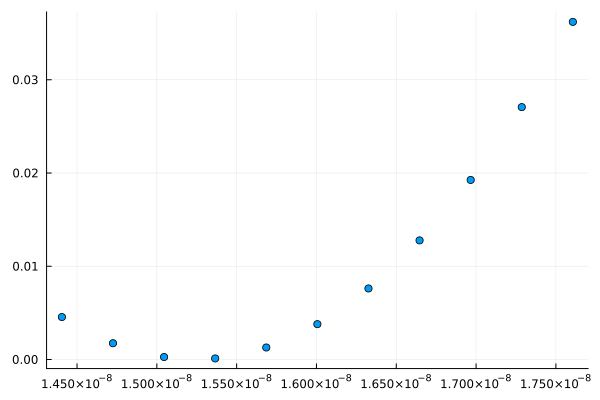

In [17]:
xa = 0.9*p[5]
xb = 1.1*p[5]
xrange = range(xa, stop=xb, length=11)
errores = errfcn.(xrange)

scatter(xrange, errores, legend=false)

### 4.3 -  Lortu $x$-ren balio horien artean $x = x_ {min}$ balioa, errfcn (x) hondarraren baliorik txikiena hartzen duena, eta alderatu balio hori $x = G\, m_5$-rekin lortzen zenarekin.

In [18]:
imin = argmin(errores)
xmin = xrange[imin]

(errfcn(p[5]), errfcn(xmin))

(0.0037879715008089115, 0.00011176631647621301)

### 4.4 - Errepikatu orain 3.4 ataleko grafikoa, baina $G\, m_5$ erabili beharrean, $p_5=x_ {min}$ hartuta

In [19]:
p_[5] = xmin
tspan = (0.,datos_t[end])
h = 300.
sol_ = solve(prob_, Vern9(), adaptive=false, dt=h, saveat=datos_t)
sol_.retcode

:Success

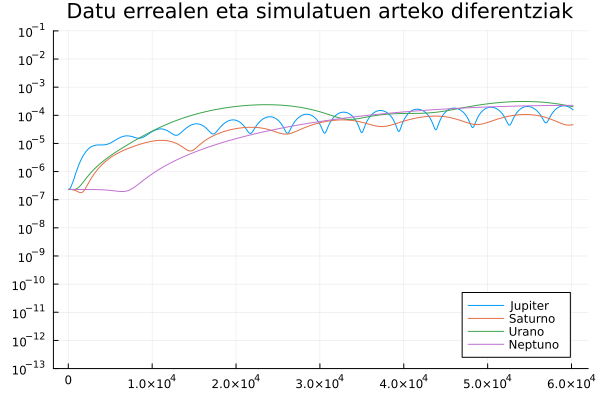

In [20]:
errores_ = [sol_.u[i] - datos_u[i] for i in 1:length(datos_t)]


ErroresPosicion_(j)=[norm(errores_[i][:,j,1])  for i in 1:length(datos_t)]

ind = 2:N

plot(datos_t, [ErroresPosicion_(i) for i in ind], title="Datu errealen eta simulatuen arteko diferentziak",
               yscale=:log10, labels=bodylist[:,ind], legend=:bottomright, ylim=(1e-13,1e-1), 
               yticks= 10. .^ (-13:-1))

Oraingoan, 3.4 ataleko diferentzien aldean, diferentzia txikiagoak lortu beharko lirateke. Alegia, masaren balio berriarekin, emaitza simulatuak datu errealetara hobe doitzen dira.

## 5 - Neptunoren masaren doikuntza zehatzagoa

Hemen, $G\, m_5 $-ren balioaren doikuntza zehatzagoa egiteko,

- Errfcn(x) funtzioa $x = x_\min $-ren inguruan hurbilduko dugu 2. mailako $P_2 (x)$ polinomio baten bidez, errfcn(x) funtzioarekin bat datorrena $x$ aldagaiaren ondoko hiru balioetan: $x_\min$, eta $x_\min$-en gertuen dituen xrange-ko bi $x$-en balioak.

- Errfcn(x) minimizatzen duen $x$-ren balioa honela hurbilduko dugu: $P '_2 (x) = 0$ ekuazioa askatuko dugu. Horrela lortutako $x$-ren balio horrek $P_2(x)$ minimizatzen duela egiaztatuko dugu, eta beraz, errfcn(x) gutxi gorabehera minimizatzen duela.

### 5.2 - Polynomials paketeko fit funtzioa erabiliz, kalkulatu $P_2 (x)$ polinomio interpolatzailea. Eskatutako hiru interpolazio-baldintzak betetzen dituela egiaztatu.

In [22]:
a = xrange[imin-1]
b = xrange[imin]
c = xrange[imin+1]
fa = errfcn(a)
fb = errfcn(b)
fc = errfcn(c)
P2 = fit([a,b,c],[fa,fb,fc])

Polynomial(1.5047546703941364 - 1.974420973153621e8*x + 6.476758736250666e15*x^2)

In [23]:
(p[5],a, b, c)

(1.6005752152793658e-8, 1.504540702362604e-8, 1.5365522066681914e-8, 1.5685637109737786e-8)

In [24]:
(P2(a)-fa, P2(b)-fb, P2(c)-fc)

(-1.5997403055023618e-16, -1.926762785778302e-16, -1.242495689668388e-16)

### 5.3 - Kalkulatu $x=x_\min^*$ non $P_2'(x)=0$ den
_Oharra_: Polynomials paketearekin lortutako P2 polinomioaren koefizienteen bektorea P2.coeffs moduan lor daiteke.

In [25]:
xmin_ = -P2.coeffs[2]/(2*P2.coeffs[3])

1.524235388067423e-8

### 5.4 - Konparatu $x = x_\min^*$ berri honen errfcn(x) balioa (4.3 atalean lortutako) errfcn($x_\min$) balioarekin


In [26]:
(errfcn(xmin_)), errfcn(xmin)

(1.3508808129233992e-5, 0.00011176631647621301)

Oharra: 5.3 atalean lortutako $x =x_\min^*$  balio optimorako errfcn(x) balioa errfcn($x_\min$) baino zertxobait txikiagoa izan beharko litzateke.

### 5.5 Errepikatu orain 3.4 eta 4.4 ataletako grafikoak, baina oraingoan $p_5 = x_\min^*$-ren balio berriari dagokion simulazioarekin

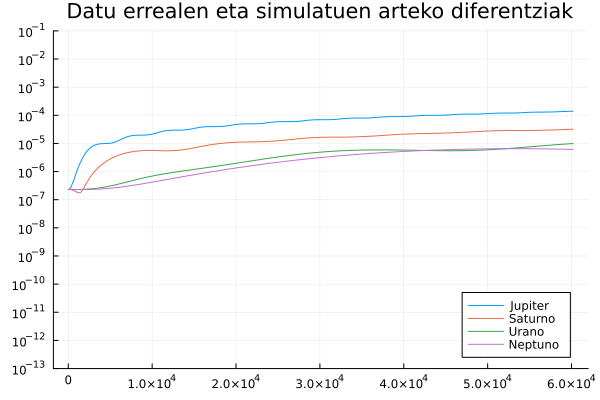

In [27]:
p_[5] = xmin_
tspan = (0.,datos_t[end])
h = 300.
sol_ = solve(prob_, Vern9(), adaptive=false, dt=h, saveat=datos_t)

errores_ = [sol_.u[i] - datos_u[i] for i in 1:length(datos_t)]


ind = 2:N

plot(datos_t, [ErroresPosicion_(i) for i in ind], title="Datu errealen eta simulatuen arteko diferentziak",
               yscale=:log10, labels=bodylist[:,ind], legend=:bottomright, ylim=(1e-13,1e-1), 
               yticks= 10. .^ (-13:-1))

### 5.6 Datu errealetara hobeto egokitzen al da eredu matematikoaren soluzioa $p_5= x_\min^*$ balioarekin?

> Erantzuna hemen idatzia

## 6 - Helburu funtzioaren Neptunoren masarekiko deribatu partzialaren kalkulua

Hemen, $G\, m_5 $-ren balioaren doikuntzaren ontasuna egiaztatzeko eta doikuntza zehatzagoa egin ahal izateko

- Errfcn(x) funtzioaren deribatua inplementatuko dugu, eta  deribatua $x = x_\min$ puntuan balioztatuko dugu, helburu funtzio horren minimotik gertu dagoen egiaztatzeko

- Errfcn(x) funtzioaren deribatua erabiliz, ekuazioak ebazteko erdibitze metodoa aplikatuko dugu, doikuntza hobeagoa lortzeko.

In [6]:
function NbodyODEBar!(dU,U,p,t)
    # Hemen, du taulan jarriko dira $f(t,u,p)$ aplikazioaren osagaiak. 
    N = length(p)
    dU[:,:,2] .= 0
    dU[:,:,4] .= 0
    for i in 1:N
       xi = U[1,i,1]
       Dxi = U[1,i,3]
       yi = U[2,i,1]
       Dyi = U[2,i,3]
       zi = U[3,i,1]
       Dzi = U[3,i,3]
       Gmi = p[i]
       DGmi = i==5 ? 1 : 0
       for j in (i+1):N
          xij = xi - U[1,j,1]
          yij = yi - U[2,j,1]
          zij = zi - U[3,j,1]
          Dxij = Dxi - U[1,j,3]
          Dyij = Dyi - U[2,j,3]
          Dzij = Dzi - U[3,j,3]

          Gmj = p[j] 
          Dgmj = j==5 ? 1 : 0
          
          dotij = xij^2+yij^2+zij^2
          Ddotij= 2* xij*Dxij + 2*yij*Dyij + 2*zij*Dzij
          
          auxij = 1/(sqrt(dotij)*dotij) 
          Dauxij = -3 * Ddotij/(2 * sqrt(dotij^5)) 

          dU[1,i,2] -= Gmj*auxij*xij
          dU[1,j,2] += Gmi*auxij*xij
          dU[2,i,2] -= Gmj*auxij*yij
          dU[2,j,2] += Gmi*auxij*yij
          dU[3,i,2] -= Gmj*auxij*zij
          dU[3,j,2] += Gmi*auxij*zij

          dU[1,i,2] -= Dgmj*auxij*xij + Gmj*Dauxij*xij + Gmj*auxij*Dxij
          dU[1,j,2] += Dgmi*auxij*xij + Gmj*Dauxij*xij + Gmj*auxij*Dxij
          dU[2,i,2] -= Dgmj*auxij*yij + Gmj*Dauxij*yij + Gmj*auxij*Dyij
          dU[2,j,2] += Dgmi*auxij*yij + Gmj*Dauxij*yij + Gmj*auxij*Dyij
          dU[3,i,2] -= Dgmj*auxij*zij + Gmj*Dauxij*zij + Gmj*auxij*Dzij
          dU[3,j,2] += Dgmi*auxij*zij + Gmj*Dauxij*zij + Gmj*auxij*Dzij
       end
    end
   dU[:,:,1] .= U[:,:,2]
   dU[:,:,1] .= U[:,:,4]    
   return nothing
end




NbodyODEBar! (generic function with 1 method)

In [ ]:
U0 = 

In [ ]:
U = rand()